In [6]:
#1. Module Import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Knowing the data 
data_dir = 'datasets/test/'
classes = []
for folder in os.listdir(data_dir):
    classes.append(folder)
num_classes = len(classes)
print(num_classes)

525


In [ ]:
# Knowing the data 
data_dir = '/kaggle/input/100-bird-species/test/'
classes = []
for folder in os.listdir(data_dir):
    classes.append(folder)
num_classes = len(classes)
print(num_classes)

In [16]:
batch_size = 32
test_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_dataset = torchvision.datasets.ImageFolder(root="./datasets/test", transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [3]:
# loading the model architecture
model = torchvision.models.resnet50(pretrained=True)

# freezing all the parameters from training
for param in model.parameters():
    param.require_grad = False

# adding a fc layer with relu activation and a dropout layer to prevent overfitting then output layer with num of classes
model.fc = nn.Sequential(nn.Linear(model.fc.in_features,1024),
                         nn.ReLU(),
                         nn.Dropout(0.3),
                         nn.Linear(1024,num_classes))

c:\Users\theos\anaconda3\envs\EC4209\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\theos\anaconda3\envs\EC4209\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
criterion = nn.CrossEntropyLoss()

In [9]:
# loading the model to evaluate
model.load_state_dict(torch.load('./models/temp.pth', map_location=torch.device('cpu')), strict=False)

<All keys matched successfully>

In [11]:
# testing how good the model is
def evaluate(model,criterion):
    model.eval()       # setting the model to evaluate mode
    test_loss = 0.0
    test_acc = 0.0
    preds = []
    labels_list = []
    
    for inputs,labels in test_loader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # predicting
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            _,pred = torch.max(outputs,dim=1)
            preds.append(pred)
            labels_list.append(labels)
        
        # calculating the loss and accuracy 
        test_loss += loss.item()*inputs.size(0)        
        correct = pred.eq(labels.data.view_as(pred))
        accuracy = torch.mean(correct.type(torch.FloatTensor))
        test_acc += accuracy.item() * inputs.size(0)
    
    # avreging the loss and accuracy
    test_loss = test_loss/len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset)
        
    print("test loss: {:.4f}  test acc: {:.4f}".format(test_loss,test_acc))
    return preds,labels_list

In [17]:
# testing the model
predictions,labels = evaluate(model,criterion)
predictions

test loss: 0.0515  test acc: 0.9859


([tensor([519,   0,   0,   0,   0,   1,   1,   1,   1,   1,   2,   2,   2,   2,
            2,   3,   3,   3,   3,   3,   4,   4,   4,   4,   4,   5,   5,   5,
            5,   5,   6,   6]),
  tensor([ 6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
          10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12]),
  tensor([12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16,
          16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19]),
  tensor([19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22,
          22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25]),
  tensor([25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29,
          29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31]),
  tensor([32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35,
          35, 35, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38]),
  tensor([ 38,  38,  38,  39,  39,  39,  39,  39,  40,  40

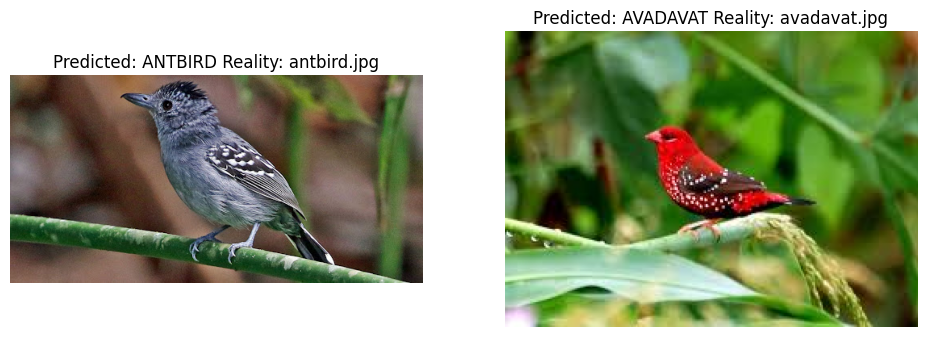

In [10]:
img_path = []
for file in os.listdir('./imagesTest/'):
    img_path.append('./imagesTest/'+file)
imgs = []
predictions = []
for img_url in img_path:
    img = Image.open(img_url)
    imgs.append(img)
    img_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    img = img_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    model.eval()
    outputs = model(img)
    _,pred = torch.max(outputs,dim=1)
    predictions.append(classes[pred])
    
plt.figure(figsize=(50,50))
for n in range(len(imgs)):
    plt.subplot(8,8,n+1)
    plt.imshow(imgs[n])
    plt.title("Predicted: "+predictions[n]+ " Reality: "+ img_path[n].split('/', 3)[2] )
    plt.axis('off')